[View in Colaboratory](https://colab.research.google.com/github/ktaletsk/CPF/blob/master/CPF_1D_toy.ipynb)

# Coarse-graining of Brownian dynamics of toy model
Predicting the first passage time using the constant probability flux (CPF) method.
 This is Jupyter notebook written in Python language. You can run each cell by pressing CTRL+SHIFT on your keyboard. Reproduce results pulished in paper and feel free to make changes and use this code in your research

## Define variables and functions and generate simulation code

In [0]:
from sympy import *
from sympy.utilities.codegen import codegen
import numpy as np
from IPython.display import Markdown
import matplotlib.pyplot as plt
# import scipy.integrate as integrate
from IPython.display import HTML, Math

In [0]:
def latex_print(expr):
  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/" "latest.js?config=default'></script>"))
  return Math(latex(expr))

In [0]:
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

Consider a detailed dynamics, say MD, with the trajectory of some interesting species can reasonably be mapped to dynamics along a single reaction coordinate $x$.
It might then be desirable to coarse grain these simulations to a nonlinear, stochastic differential equation.
It is well established that such dynamics are equivalently described by a Fokker-Planck (or Smoluchowski) equation

\begin{equation}
\frac{\partial p}{\partial t} =
    \frac{\partial}{\partial x}\frac{1}{\zeta} \left[ \left(\frac{dF^\text{CG}}{d x}\right) p
    + k_\text{B}T \frac{\partial p}{\partial x}
    \right],
\end{equation}

where $p\equiv p(x;t|x_0;t_0)$ is the probability density of finding the species in the neighborhood of $x$ at time $t$, given that it had coordinate $x_0$ at some earlier time $t_0$.

The equivalent Ito-form stochastic differential equation is
\begin{equation}
dx = \left( \frac{d \zeta^{-1}}{d x} - \zeta^{-1} \frac{d F}{dx} \right) dt + \sqrt{2 \zeta^{-1}} d W_t
\end{equation}

We chose free energy of our toy system in a form:
\begin{equation}
\frac{F}{k_B T} = H_0 (1-x_0)^2 + \sum_{i=1}^{n-1} H_i (x_i - \mu_i)^2
\end{equation}
where $\mu_i=\frac{\sin A(x_0-C_i)}{B_i}$ 

In [0]:
#Number of dimensions
n=1

In [0]:
A = []
B = []
C = []
H = [4]

In [0]:
#Define variables
x = symbols('x0:%d'%n)

def floor(x,A,B,C):
    return sin(A*(x-C))/B

def wall(x,y,A,B,C):
    return (y - floor(x,A,B,C))**2

def free_energy(n, x):
    result = H[0]*(1-x[0])**2
    for i in range(1, n):
        result += H[i] * wall(x[0], x[i], A[i-1], B[i-1], C[i-1])
    return result

def free_energy_CG(x):
    return H[0]*(1-x[0])**2

def zeta_inv(n, x):
    return 0.5*(1+x[0]**2)**2 #friction

def tshift(n,x,i):
    return diff(zeta_inv(n,x), x[i])-zeta_inv(n, x)*diff(free_energy(n,x), x[i])

def wshift(n,x):
    return sqrt(2.0*zeta_inv(n, x))

**Free energy of our {two}-dimensional toy model**

In [8]:
latex_print(free_energy(n, x))

<IPython.core.display.Math object>

In [0]:
xx = MatrixSymbol('x', 1, n)
dx = MatrixSymbol('dx', 1, n)
dWt = MatrixSymbol('dWt', 1, n)
dt = symbols('dt')
subs_rule = list(zip(x,xx))
array = [(tshift(n,x,i) * dt + wshift(n,x) * dWt[i]).subs(subs_rule) for i in range(n)]
m = Matrix(1, n, array)
equation = Eq(dx, m)

In [10]:
latex_print(equation)

<IPython.core.display.Math object>

**Calculate equilibrium distribution**

\begin{equation}
p(x_i | x_0) = \frac{p(x_i, x_0)}{p(x_0)}
\end{equation}

In [0]:
p = symbols('p0:%d'%(n-1))
pp = MatrixSymbol('p', 1, n)
xx = MatrixSymbol('x', 1, n)
xa = symbols('xa')

subs_rule2 = list(zip(p,pp))
subs_rule2.insert(0,(x[0],xa))

array2 = [(floor(x[0],A[i],B[i],C[i]) + p[i]/sqrt(2*H[i+1])).subs(subs_rule2)  for i in range(0,n-1)]
array2.insert(0,xa)
m2 = Matrix(1, n, array2)
equation2 = Eq(xx, m2)

In [12]:
latex_print(equation2)

<IPython.core.display.Math object>

### Generate code for timestep and initialization

In [0]:
from google.colab import files
files.upload()

In [0]:
codegen(("shift",equation), "C", "shift", header=False, empty=False, to_files=True)
codegen(("init",equation2), "C", "init", header=False, empty=False, to_files=True)

In [0]:
#Put source files 'FPT-gen.cpp' and 'CPF-gen.cpp' in the same folder as this notebook!
! g++ FPT-gen.cpp shift.c init.c -o FPT-gen
! g++ CPF-gen.cpp shift.c init.c -o CPF-gen
#! g++ EQ-gen.cpp shift.c init.c -o EQ-gen

In [0]:
!./CPF-gen

## Processing CPF results

In [0]:
with open('cpf.dat') as f:
    lines = f.readlines()
    x0 = np.array([float(line.split()[0]) for line in lines])
    x0.sort()

In [19]:
x0.shape[0]

2000036

In [0]:
P = np.arange(0.0, 1.0, 1.0/x0.shape[0])

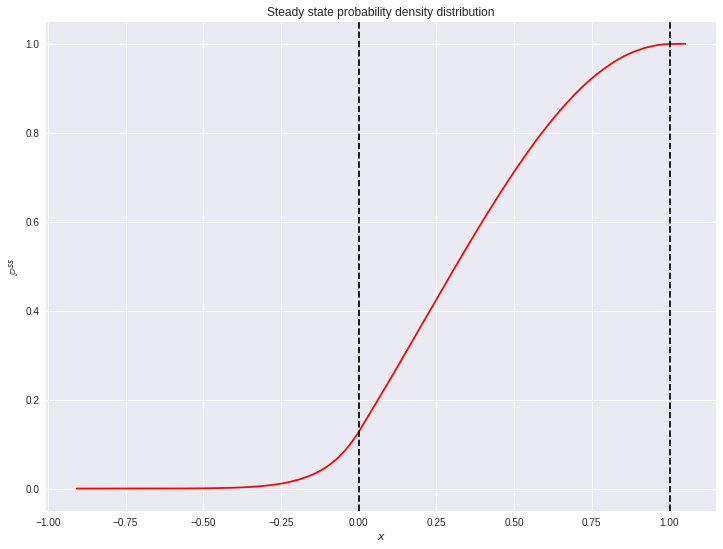

In [21]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.set_title("Steady state probability density distribution")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\mathbb{P}^{ss}$')
ax1.plot(x0,P, c='r', label=r'$f_d(t)$')
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1,  color='k', linestyle='--')
plt.show()

### Using [Kernel Density Estimation](http://scikit-learn.org/stable/modules/density.html) to find PDF in steady state

In [22]:
#Rule of thumb bandwith for kernel density estimstor
h = 1.06*np.std(x0)*np.size(x0)**(-0.2)
h

0.016404252185212288

In [0]:
def myKernelDensity(x, h, xi):
    return np.sum(np.exp(-(x-xi)**2/(2*h**2)))/len(xi)
def myKernelDensityDerivative(x, h, xi):
    return np.sum(-(x-xi)/h**2*np.exp(-(x-xi)**2/(2*h**2)))/len(xi)

In [0]:
X_plot = np.linspace(0.0, 1.0, 1000)

In [0]:
mydens = [myKernelDensity(i, h, x0) for i in X_plot]

In [0]:
mydensder = [myKernelDensityDerivative(i, h, x0) for i in X_plot]

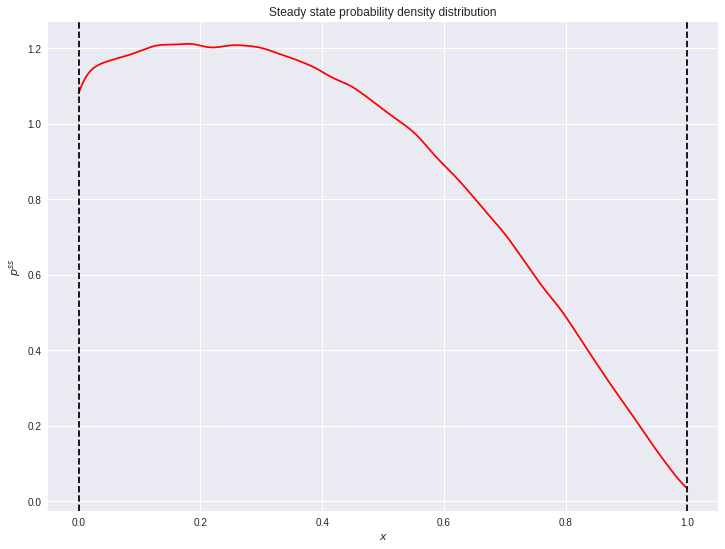

In [81]:
fig2 = plt.figure(figsize=(12, 9))
ax2 = fig2.add_subplot(111)
ax2.set_title("Steady state probability density distribution")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$p^{ss}$')
ax2.plot(X_plot, np.array(mydens)/np.sqrt(2*np.pi*h**2), c='r')
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1,  color='k', linestyle='--')
plt.show()

In [0]:
pCG = lambdify(x[0], exp(-free_energy_CG(x))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")

In [0]:
PCG = lambdify(x[0], simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,x[0])))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")

In [0]:
with open('flux.dat') as f:
    lines = f.readlines()
J0 = float(lines[-1].split()[1])/float(lines[-1].split()[0])

In [0]:
xr=1

In [0]:
arr1 = np.array([(N(PCG(xr))-N(PCG(xT)))/N(pCG(xT))/J0 for xT in X_plot], dtype="float")

In [87]:
N(PCG(2))

0.997661132509476

## Friction

### 1. Friction from KDE of $p^{ss}$

In [0]:
dFdx = lambdify(x[0],diff(free_energy_CG(x)))

In [0]:
actual_friction = lambdify(x[0],zeta_inv(n, x))

In [0]:
dFdX_arr = [dFdx(i) for i in X_plot]

In [0]:
friction = -(np.multiply(mydens,dFdX_arr)+mydensder)/J0/np.sqrt(2*np.pi*h**2)

In [0]:
act_f = [1/actual_friction(i) for i in X_plot]

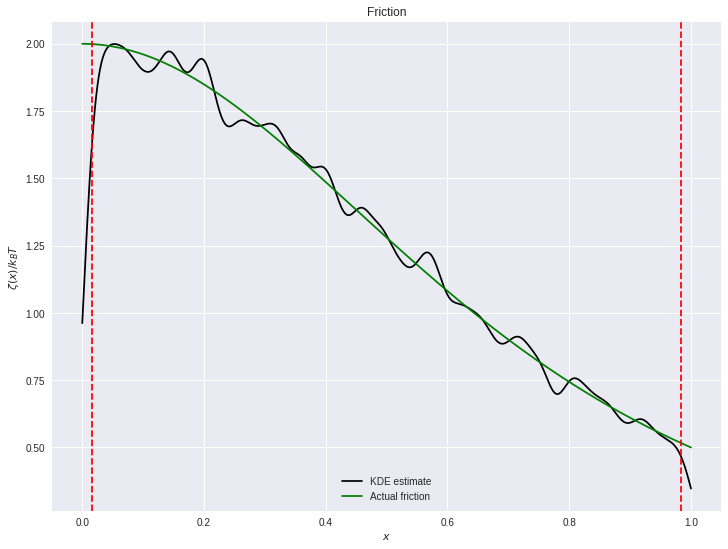

In [95]:
fig5 = plt.figure(figsize=(12, 9))

ax5 = fig5.add_subplot(111)

ax5.set_title("Friction")
ax5.set_xlabel(r'$x$')
ax5.set_ylabel(r'$\zeta(x)/k_B T$')

ax5.plot(X_plot, friction, c='k',label='KDE estimate')
ax5.plot(X_plot, act_f, c='g', label='Actual friction')
plt.axvline(x=h, color='r', linestyle='--')
plt.axvline(x=xr-h, color='r', linestyle='--')
plt.legend()
plt.show()

### 2. Fitting friction with a sum of Chebyshev polynomials

\begin{equation}
\mathbb{P}^\text{ss}(x) =
\int_{x_s}^{x}
 \mathbb{P}^\text{eq}(x')
 \frac{\tilde{\zeta}(x')}{p^\text{eq}(x')} dx' +
 \mathbb{P}^\text{eq}(x)
 \int_{x}^{x_a}
 \frac{\tilde{\zeta}(x')}{p^\text{eq}(x')} dx'
\end{equation}
where 
\begin{equation}
\tilde{\zeta}(x) := \frac{J_0 \zeta(x)}{k_\text{B}T}
\end{equation}

We fit friction with the sum of Chebychev's polynomials, so that
\begin{equation}
\tilde{\zeta}(x) = \sum_i c_i T_i(x)
\end{equation}

\begin{equation}
\mathbb{P}^\text{ss}(x) = \sum_i c_i \left( \int_{x_s}^{x}
 \mathbb{P}^\text{eq}(x')
 \frac{T_i(x')}{p^\text{eq}(x')} dx' +
 \mathbb{P}^\text{eq}(x)
 \int_{x}^{x_a}
 \frac{T_i(x')}{p^\text{eq}(x')} dx' \right) = 
\sum_i c_i I_i(x)
\end{equation}

We define the set of reference points $\{ x_j \}$ and solve matrix equation
\begin{equation}
c_i I_i(x_j) = \mathbb{P}^{ss}(x_j)
\end{equation}
to find the set of weights $\{c_i\}$

In [0]:
import scipy.integrate
def integral1(n, lower, upper):
    return scipy.integrate.quad(lambda x: PCG(x)*chebyshevt_poly(n,x)/pCG(x), lower, upper)[0]

def integral2(n, lower, upper):
    return scipy.integrate.quad(lambda x: chebyshevt_poly(n,x)/pCG(x), lower, upper)[0]

def Pss_cheb(x, n, L0, La):
    return integral1(n,L0,x)+N(PCG(x))*integral2(n,x,La)
  
# def PSS_func(x):
  

In [0]:
from scipy.interpolate import interp1d
PSS_func = interp1d(x0, P)

In [114]:
PSS_func(0.5)

array(0.71209068)

In [135]:
nmodes=7 #number of Chebyshev polynomials (starting from 0-th)
npoints=500 #reference points in domain
III = [[Pss_cheb(float(j)/npoints, i, 0, 1) for i in range(nmodes)] for j in range(npoints)]
rhs = [PSS_func(float(j)/npoints) for j in range(npoints)]
fit = np.linalg.lstsq(III, rhs, rcond=-1)[0]
fit

array([-10.53150401,  25.45572177, -17.37317627,   4.31277377,
         1.91851337,  -1.70963094,   0.63738055])

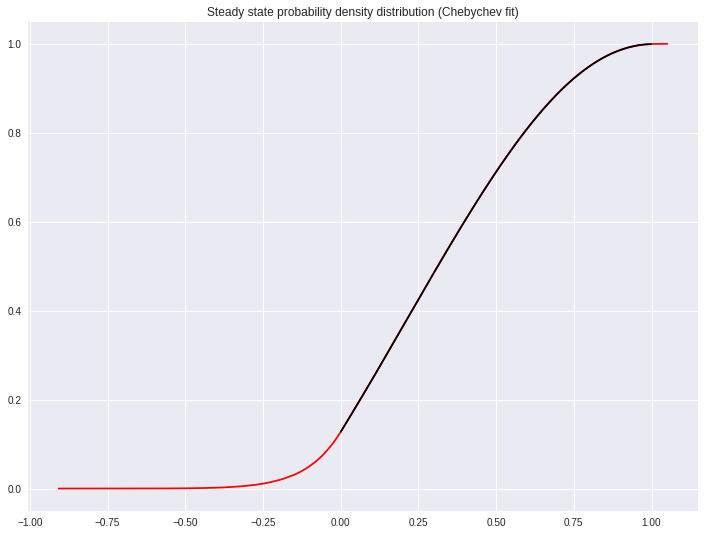

In [150]:
fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(111)

ax1.set_title("Steady state probability density distribution (Chebychev fit)")
# ax1.set_xlabel(r'$t/\tau_c$')
# ax1.set_ylabel(r'$f_d(t)$')

ax1.plot(x0,P, c='r', label=r'$f_d(t)$')
ax1.plot(np.arange(float(npoints))/npoints, [sum([fit[i]*Pss_cheb(float(j)/npoints, i, 0, 1) for i in range(nmodes)]) for j in range(npoints)], c='k', label='Chebychev approximation')


#plt.xlim(xmin=-1.1, xmax=-0.9)
#plt.ylim(ymin=0, ymax=0.05)
# leg = ax1.legend()
#ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.show()

In [0]:
cheb_friction = [sum([fit[i]*chebyshevt_poly(i,j)/J0 for i in range(nmodes)]) for j in X_plot]

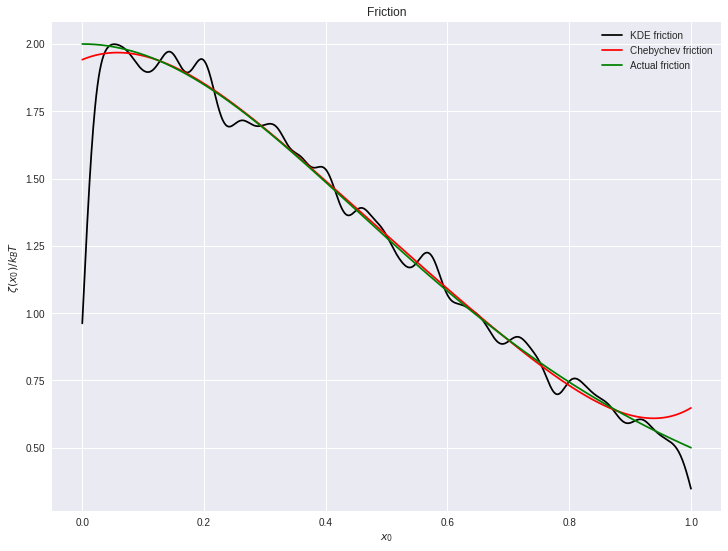

In [149]:
fig5 = plt.figure(figsize=(12, 9))

ax5 = fig5.add_subplot(111)

ax5.set_title("Friction")
ax5.set_xlabel(r'$x_0$')
ax5.set_ylabel(r'$\zeta(x_0)/k_B T$')

ax5.plot(X_plot, friction, c='k', label='KDE friction')
ax5.plot(X_plot, cheb_friction, c='r', label='Chebychev friction')
ax5.plot(X_plot, act_f, c='g', label='Actual friction')
leg = ax5.legend()

plt.show()

**This is it! Feel free now to try different friction function and/or free energy for this system**